In [1]:
#region imports
from IPython import get_ipython

# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass

# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import cartopy as crt
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
import bnn_tools.bnn_array
import bnn_tools.basic_funs as bu
import funs as fu

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);
#endregion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dn = (
    xr.open_dataset('../data/d1/npsd-hy-nais.nc')
    .expand_dims({'id':['nais']})
)

ds = (
    xr.open_dataset('../data/d1/npsd-hy-dmps.nc')
    .expand_dims({'id':['dmps']})
)

In [3]:
d1 = (
    xr.concat([dn,ds],dim='id')
    .drop('lDp')
)
d1

<xarray.Dataset>
Dimensions:  (Dp: 52, time: 175293, id: 2)
Coordinates:
  * Dp       (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * time     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T23:00:00
  * id       (id) object 'nais' 'dmps'
Data variables:
    dndlDp   (id, time, Dp) float64 1.167e+03 914.7 741.2 ... 5.461 7.81 3.218

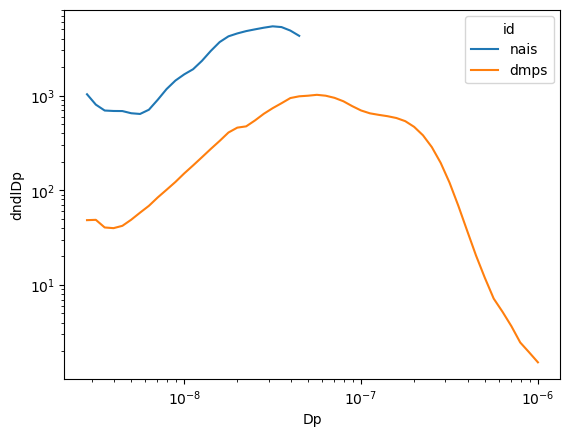

In [4]:
(
    d1
    .median('time')
    ['dndlDp']
    .plot(
        hue='id',
        yscale='log',
        xscale='log'
    )
)

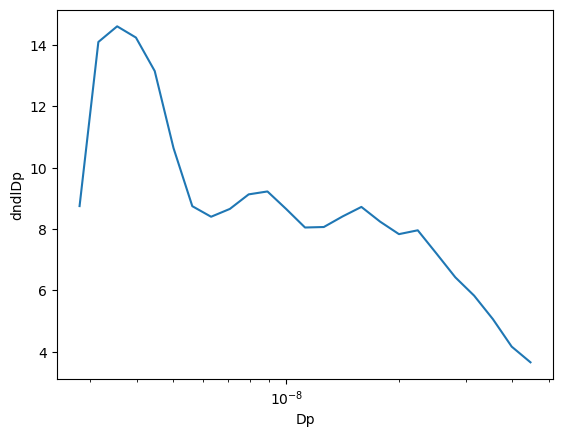

In [5]:
(
    d1
    .pipe(lambda d:(
              d.loc[{'id':'nais'}] /
              d.loc[{'id':'dmps'}]
            )
          )
    .median('time')
    ['dndlDp']
    .plot(
        hue='id',
        # yscale='log',
        xscale='log'
    )
)

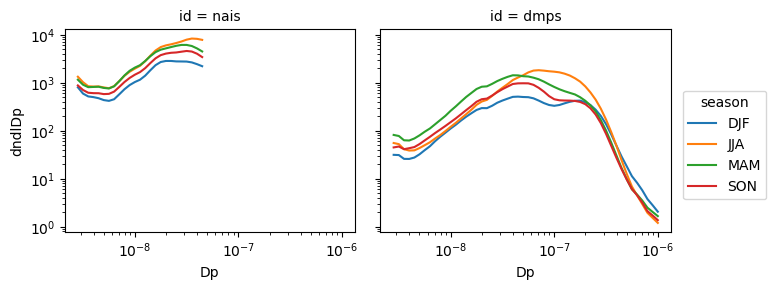

In [6]:
(
    d1
    .assign({'season':lambda d:d['time'].dt.season})
    .groupby('season')
    .median('time')
    ['dndlDp']
    .plot(
        hue='season',
        col='id',
        yscale='log',
        xscale='log'
    )
)

In [7]:
d1['Dp'].min()

<xarray.DataArray 'Dp' ()>
2.818e-09

In [8]:
def get_nais_dmps(d):
    d1 = d[['dndlDp']].loc[{'id':'nais','Dp':slice(0,2.e-8)}]
    d2 = d[['dndlDp']].loc[{'id':'dmps','Dp':slice(2.e-8+.00001e-8,1)}]*2
    dc = xr.concat([d1, d2], dim='Dp')
    dc['id'] = 'nd'

    dcc = xr.concat([d,dc],dim='id')
    return dcc

In [9]:
d2 = (
    d1
    .pipe(get_nais_dmps)
    .assign({'N':lambda d:bu.get_exact_N(d.loc[{'id':'nais'}]['dndlDp'],2.82e-9,5e-9)})
    .assign({'lN':lambda d:np.log10(d['N'])})
)

d2

/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:      (Dp: 52, time: 175293, id: 3, Dp_interval: 1)
Coordinates:
  * Dp           (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * time         (time) datetime64[ns] 2018-01-01 ... 2022-12-31T23:00:00
  * id           (id) object 'nais' 'dmps' 'nd'
  * Dp_interval  (Dp_interval) object (2.82e-09, 5e-09]
Data variables:
    dndlDp       (id, time, Dp) float64 1.167e+03 914.7 741.2 ... 15.62 6.437
    N            (Dp_interval, time) float64 155.1 238.6 240.9 ... nan nan nan
    lN           (Dp_interval, time) float64 2.191 2.378 2.382 ... nan nan nan

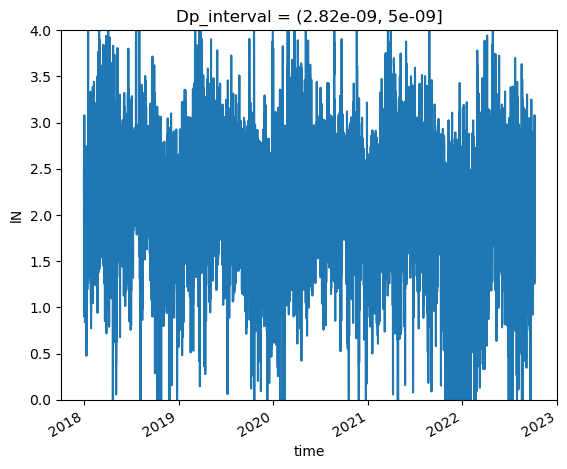

In [10]:
(
    d2
    ['lN']
    .plot(ylim=(0,4))
)

In [11]:
(
    d2
    .pipe(fu.unstack_day)

)

<xarray.Dataset>
Dimensions:      (day: 1826, hour: 96, Dp: 52, id: 3, Dp_interval: 1)
Coordinates:
  * day          (day) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
  * hour         (hour) float64 0.0 0.25 0.5 0.75 1.0 ... 23.0 23.25 23.5 23.75
  * Dp           (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * id           (id) object 'nais' 'dmps' 'nd'
  * Dp_interval  (Dp_interval) object (2.82e-09, 5e-09]
    t            (day, hour) datetime64[ns] 2018-01-01 ... NaT
Data variables:
    dndlDp       (id, Dp, day, hour) float64 1.167e+03 1.587e+03 ... nan nan
    N            (Dp_interval, day, hour) float64 155.1 238.6 240.9 ... nan nan
    lN           (Dp_interval, day, hour) float64 2.191 2.378 2.382 ... nan nan

In [12]:
d3 = fu.unstack_2day(d2)

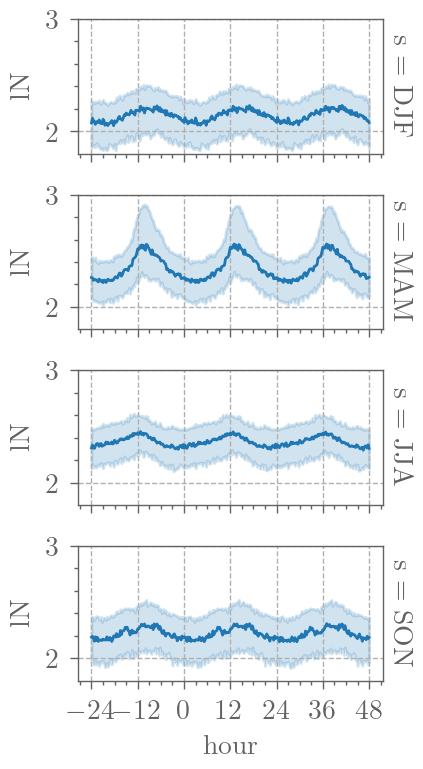

In [13]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot


res = (
    d3
    .assign_coords({'s':lambda d:d['day'].dt.season})
    ['lN']
    .to_dataframe()
    .pipe(
        lambda d:
        sns.relplot(
            data = d,
            x = 'hour',
            y='lN',
            kind = 'line',
            row = 's',
            estimator='median',
            errorbar=('pi', 50),
            height = 1,
            aspect = 2.5,
            facet_kws=dict(despine= False,sharey=False,margin_titles=True),


        )
    )
)

for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_ylim(1.8,3)


In [14]:
def count_day(d4):
    return (
        d4
        .where(lambda d:d['is_day'])
        ['N'].notnull().sum('hour')
    )

def count_night(d4):
    return (
        d4
        .where(lambda d:d['is_night'])
        ['N'].notnull().sum('hour')
    )

In [15]:
bad_day = xr.open_dataarray('../data/d1/nais_bad_day.nc')

In [16]:
d4 = (
    d3
    .assign_coords({'is_day':lambda d:((d['hour']>6) & (d['hour']<18))})
    .assign_coords({'is_night':lambda d:((d['hour']> -2) & (d['hour']<6))})
    .assign_coords({'n_day':count_day})
    .assign_coords({'n_night':count_night})
    .assign({'lN_s':lambda d:d['lN'].rolling(**{'hour':9},center=True,min_periods=2).median()})
    .assign({'N_s':lambda d:d['N'].rolling(**{'hour':9},center=True,min_periods=2).median()})
    .assign({'max_lN':lambda d:d['lN_s'].where(d['is_day']).max('hour')})
    .assign({'min_lN':lambda d:d['lN_s'].where(d['is_night']).median('hour')})
    .assign({'d_lN':lambda d:np.log10(10**d['max_lN']-10**d['min_lN'])})
    .where(lambda d:d['d_lN'].notnull())
    # .where(lambda d:d['d_lN']>-np.inf,0)
    .where(lambda d:d['d_lN']>-np.inf)

    .where(lambda d:d['n_day']>30)
    .where(lambda d:d['n_night']>10)
    .where(lambda d:~d['day'].isin(bad_day))
    # .assign({'d_lN':lambda d:(10**d['max_lN']-10**d['min_lN'])})

)

/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/aliaga/py-packs/xarray_exc/xarray/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


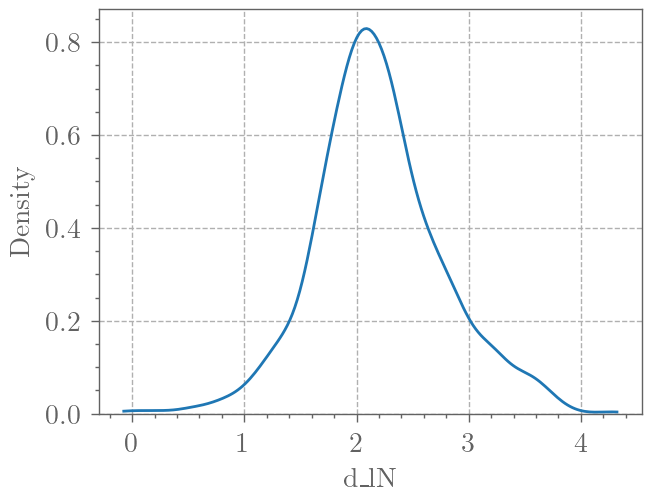

In [17]:
sns.kdeplot(
    data = d4['d_lN'].to_series(),
    bw_adjust=.98,
    clip=(d4['d_lN'].to_series().min(),d4['d_lN'].to_series().max())
    # log_scale = True
)
ax:plt.Axes = plt.gca()
# ax.set_yscale('symlog',linthresh=.05)

array([0.80375002, 2.09843028, 0.42767815, 0.07829216, 2.88631067,
       0.17232542, 0.10481556, 3.31820021, 0.31275107])

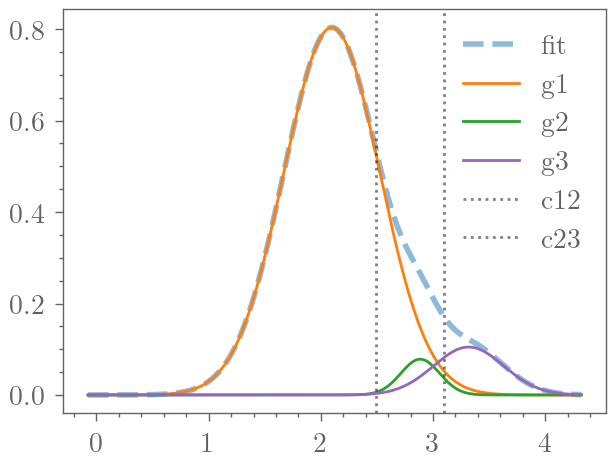

In [18]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot



# amplitude a, center c, and std s for gaussian 1
# first value is the best guess, second and third values are the lower and upper limit
# a1, a1m, a1M = (.1, 0, 3)
# c1, c1m, c1M = (2, 1.5, 2.5)
# s1, s1m, s1M = (.1, 0, 1)
#
# # amplitude a, center c, and std s for gaussian 3
# a2, a2m, a2M = (.1, 0, 3)
# c2, c2m, c2M = (2.6, 2.5, 3)
# s2, s2m, s2M = (.1, 0, .2)
#
# # amplitude a, center c, and std s for gaussian 3
# a3, a3m, a3M = (.1, 0, 3)
# c3, c3m, c3M = (3.1, 3, 4)
# s3, s3m, s3M = (.1, 0, .4)


a1, a1m, a1M = (.1, 0, 3)
c1, c1m, c1M = (2, 1.5, 2.5)
s1, s1m, s1M = (.1, 0, 1)

# amplitude a, center c, and std s for gaussian 3
a2, a2m, a2M = (.1, 0, 3)
c2, c2m, c2M = (2.6, 2.5, 3)
s2, s2m, s2M = (.1, 0, .2)

# amplitude a, center c, and std s for gaussian 3
a3, a3m, a3M = (.1, 0, 3)
c3, c3m, c3M = (3.1, 3, 4)
s3, s3m, s3M = (.1, 0, .4)

A = (a1, c1, s1, a2, c2, s2, a3, c3, s3,)
B = (a1m, c1m, s1m, a2m, c2m, s2m, a3m, c3m, s3m,)
C = (a1M, c1M, s1M, a2M, c2M, s2M, a3M, c3M, s3M,)



logn = d4['d_lN'].to_series().dropna()
mi, ma = logn.describe().T[['min', 'max']]
m12, m23, R = fu.fit_gaussians(logn, mi, ma, A, B, C, bw=.25)
R

In [19]:
xr.DataArray().rank

<bound method DataArray.rank of <xarray.DataArray ()>
nan>

In [20]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [21]:
bb = np.linspace(0, 100, 21)
d5  = (
    d4
    .assign_coords({'g':lambda d:pd.cut(d['d_lN'].to_series(),bins=[0,m12,m23,10],labels=['g1','g2','g3']).to_xarray()})
    .assign_coords({'q':lambda d:d['d_lN'].rank(pct=True,dim='day')*100})
    # .assign_coords({'qCut':lambda d:pd.cut(d['q'].to_series(), bins=bb,labels=bb[1:]).to_xarray()})
    .assign_coords({'qCut':lambda d:pd.cut(d['q'].to_series(), bins=bb,precision=1).to_xarray()})
)

d5['q'].to_series().describe()

count    1589.000000
mean       50.031466
std        28.876596
min         0.062933
25%        25.047199
50%        50.031466
75%        75.015733
max       100.000000
Name: q, dtype: float64

In [22]:
d5

<xarray.Dataset>
Dimensions:      (id: 3, Dp: 52, day: 1826, hour: 289, Dp_interval: 1)
Coordinates: (10/12)
  * Dp           (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * id           (id) object 'nais' 'dmps' 'nd'
  * Dp_interval  (Dp_interval) object (2.82e-09, 5e-09]
  * hour         (hour) float64 -24.0 -23.75 -23.5 -23.25 ... 47.5 47.75 48.0
  * day          (day) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
    ...           ...
    n_day        (Dp_interval, day) int64 47 47 47 47 47 47 47 ... 0 0 0 0 0 0 0
    n_night      (Dp_interval, day) int64 24 31 31 31 31 31 31 ... 0 0 0 0 0 0 0
    g            (Dp_interval, day) object 'g1' 'g1' 'g1' 'g1' ... nan nan nan
    q            (Dp_interval, day) float64 0.5664 70.67 16.49 ... nan nan nan
    qCut         (Dp_interval, day) object (0.0, 5.0] (70.0, 75.0] ... nan nan
Data variables:
    dndlDp       (id, Dp, day, hour, Dp_interval) float64 nan nan ... nan nan
    N            (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    lN           (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    lN_s         (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    N_s          (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    max_lN       (Dp_interval, day) float64 2.288 2.518 2.255 ... nan nan nan
    min_lN       (Dp_interval, day) float64 2.28 1.819 2.107 ... nan nan nan
    d_lN         (Dp_interval, day) float64 0.5497 2.421 1.714 ... nan nan nan

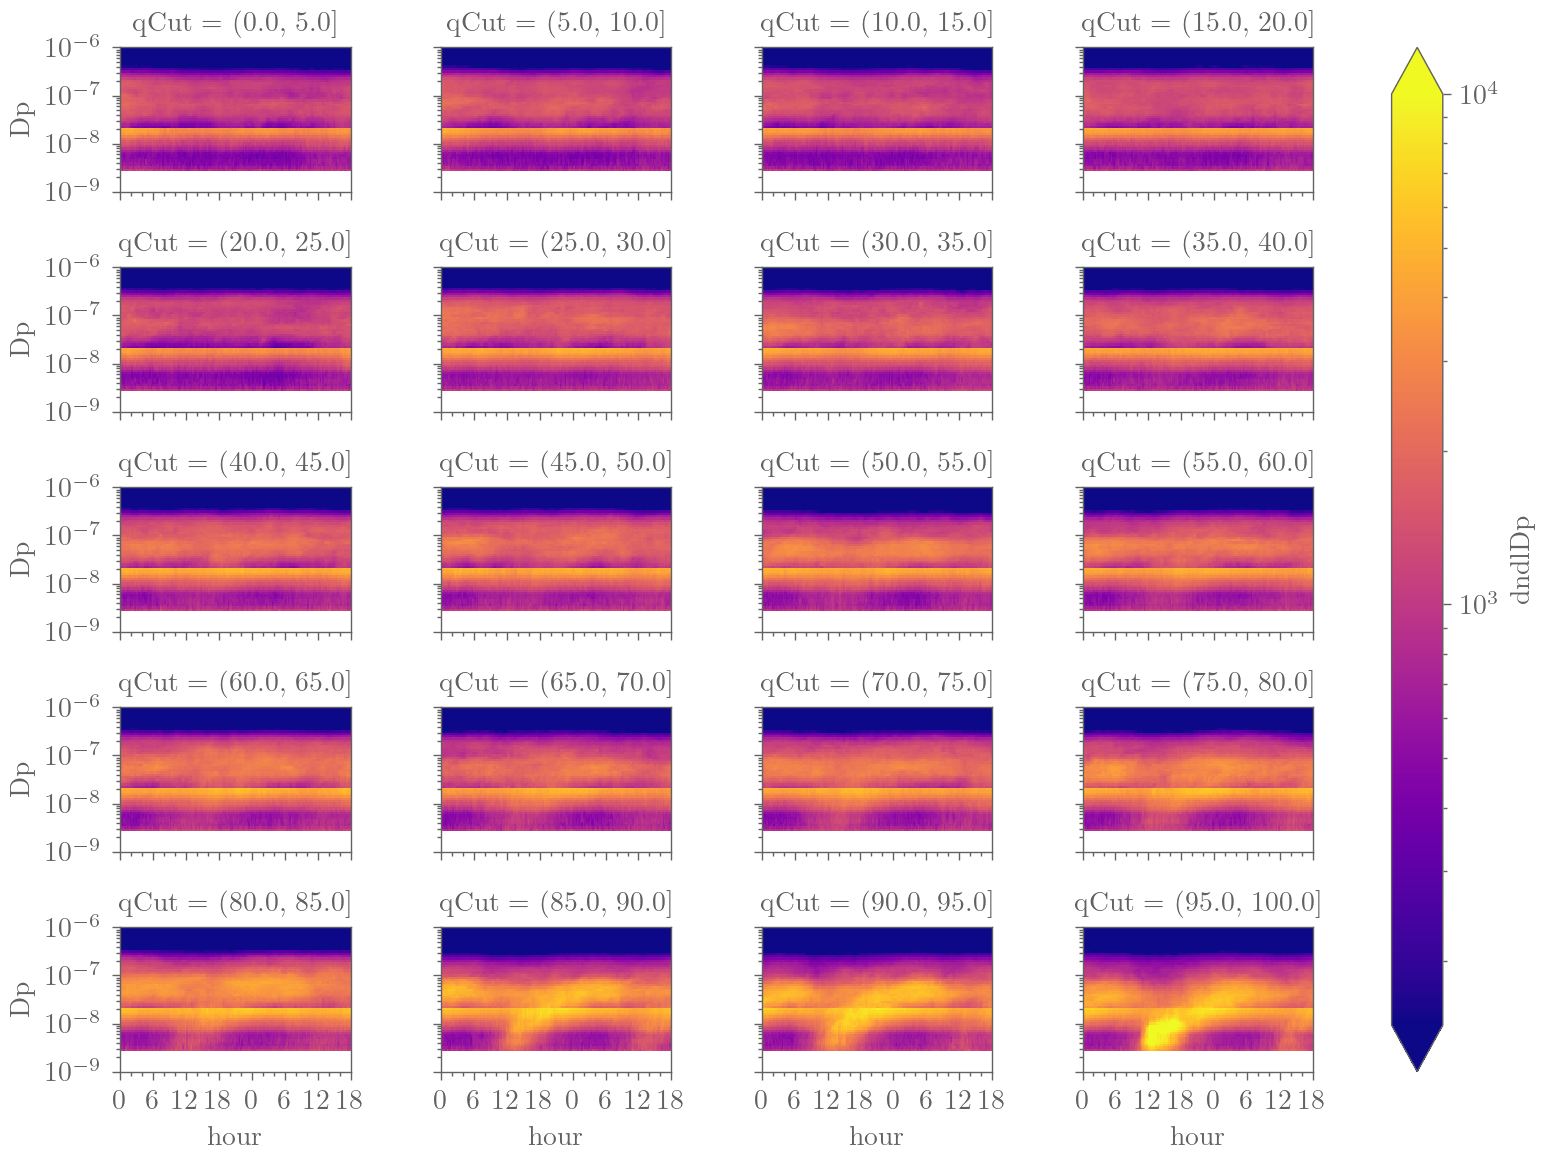

In [23]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

res = (
    d5
    [['dndlDp','qCut']]
    .groupby('qCut')
    .median()
    .loc[{'id':'nd'}]
    ['dndlDp']
    .plot(
        y='Dp',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e4),
        cmap = 'plasma',
        col='qCut',
        col_wrap=4,
        size=1.2,
        aspect = 1.6
    )

)



for ax in res.axs.flat:
    ax:plt.Axes
    ax.set_box_aspect(1/1.6)
    yy = 36 + 6
    ax.set_xlim(0,yy)
    ax.set_ylim(1e-9,1e-6)
    ti = np.arange(0, yy + 1, 6)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(0, yy+1, 2), minor=True)
    ax.set_xticklabels(np.mod(ti,24))

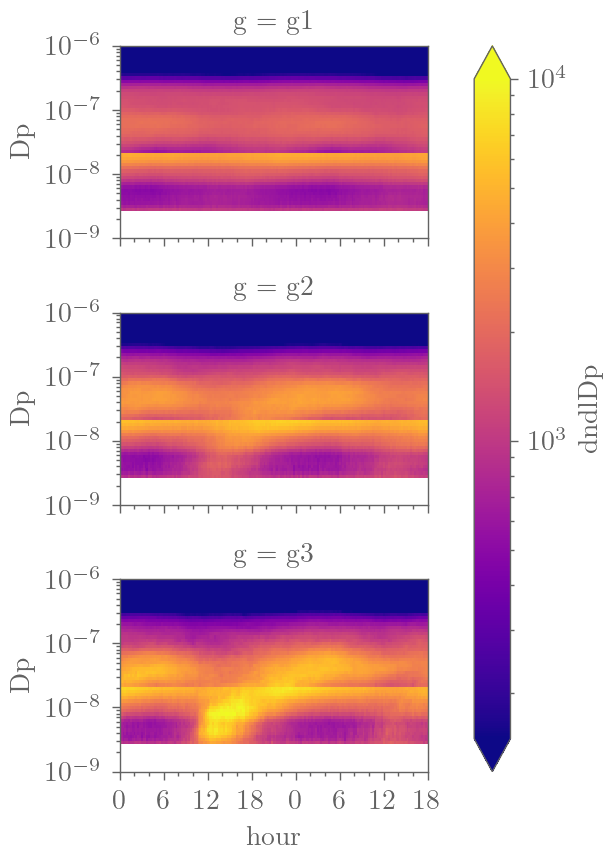

In [24]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot

res = (
    d5
    [['dndlDp','g']]
    .groupby('g')
    .median()
    .loc[{'id':'nd'}]
    ['dndlDp']
    .plot(
        y='Dp',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e4),
        cmap = 'plasma',
        row='g',
        size=1.5,
        aspect = 3
    )

)



for ax in res.axs.flat:
    ax:plt.Axes
    ax.set_box_aspect(1/1.6)
    yy = 36 + 6
    ax.set_xlim(0,yy)
    ax.set_ylim(1e-9,1e-6)
    ti = np.arange(0, yy + 1, 6)
    ax.set_xticks(ti)
    ax.set_xticks(np.arange(0, yy+1, 2), minor=True)
    ax.set_xticklabels(np.mod(ti,24))

<AxesSubplot: >

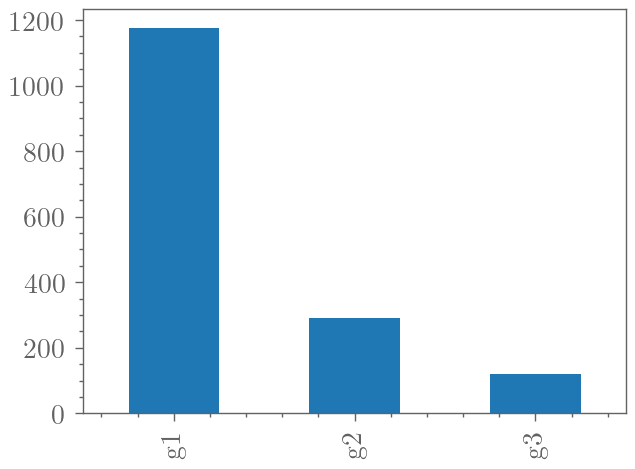

In [25]:
d5['g'].to_series().value_counts().plot.bar()

In [26]:
vc = d5['g'].to_series().value_counts()

In [27]:
vc

g1    1175
g2     291
g3     121
Name: g, dtype: int64

In [28]:
vc/vc.sum() * 100

g1    74.039067
g2    18.336484
g3     7.624449
Name: g, dtype: float64

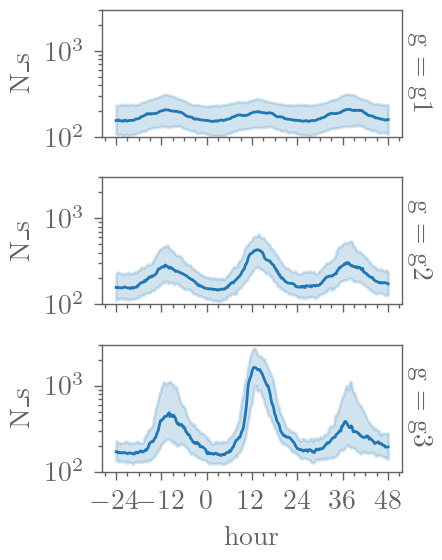

In [29]:
ser = (
    d5['N_s']
    .to_dataframe()
)

res = sns.relplot(
    data = ser,
    x = 'hour',
    y='N_s',
    kind = 'line',
    row = 'g',
    estimator='median',
    errorbar=('pi', 50),
    height = 1,
    aspect = 2.5,
    facet_kws=dict(despine= False,sharey=False,margin_titles=True),


)

for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_ylim(0,3000)
    ax.set_yscale('log')
    ax.set_ylim(1e2,3e3)


In [30]:
d5

<xarray.Dataset>
Dimensions:      (id: 3, Dp: 52, day: 1826, hour: 289, Dp_interval: 1)
Coordinates: (10/12)
  * Dp           (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 8.913e-07 1e-06
  * id           (id) object 'nais' 'dmps' 'nd'
  * Dp_interval  (Dp_interval) object (2.82e-09, 5e-09]
  * hour         (hour) float64 -24.0 -23.75 -23.5 -23.25 ... 47.5 47.75 48.0
  * day          (day) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
    ...           ...
    n_day        (Dp_interval, day) int64 47 47 47 47 47 47 47 ... 0 0 0 0 0 0 0
    n_night      (Dp_interval, day) int64 24 31 31 31 31 31 31 ... 0 0 0 0 0 0 0
    g            (Dp_interval, day) object 'g1' 'g1' 'g1' 'g1' ... nan nan nan
    q            (Dp_interval, day) float64 0.5664 70.67 16.49 ... nan nan nan
    qCut         (Dp_interval, day) object (0.0, 5.0] (70.0, 75.0] ... nan nan
Data variables:
    dndlDp       (id, Dp, day, hour, Dp_interval) float64 nan nan ... nan nan
    N            (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    lN           (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    lN_s         (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    N_s          (Dp_interval, day, hour) float64 nan nan nan ... nan nan nan
    max_lN       (Dp_interval, day) float64 2.288 2.518 2.255 ... nan nan nan
    min_lN       (Dp_interval, day) float64 2.28 1.819 2.107 ... nan nan nan
    d_lN         (Dp_interval, day) float64 0.5497 2.421 1.714 ... nan nan nan

0

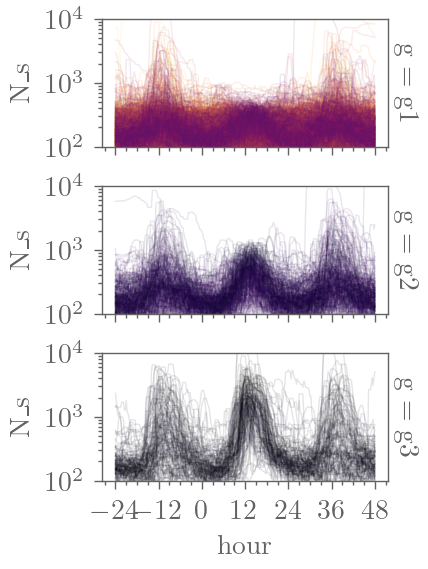

In [31]:
ser = (
    d5['N_s']
    .to_dataframe()
)

res = sns.relplot(
    data = ser,
    x = 'hour',
    y='N_s',
    kind = 'line',
    row = 'g',
    estimator=None,
    units = 'day',
    errorbar=('pi', 50),
    height = 1,
    aspect = 2.5,
    facet_kws=dict(despine= False,sharey=False,margin_titles=True),
    alpha=.1,
    lw=.5,
    legend=False,
    hue = 'q',
    palette='inferno_r'


)

for ax in res.axes.flat:
    ax.set_xticks(np.arange(-24,49,12))
    ax.set_ylim(0,3000)
    ax.set_yscale('log')
    ax.set_ylim(1e2,1e4)

#region temp open fig
_p_ = '/tmp/f.pdf';plt.gcf().savefig(_p_,transparent=True);
os.system(f'open {_p_}')
#endregion temp open fig


In [32]:
xr.DataArray

xarray.core.dataarray.DataArray

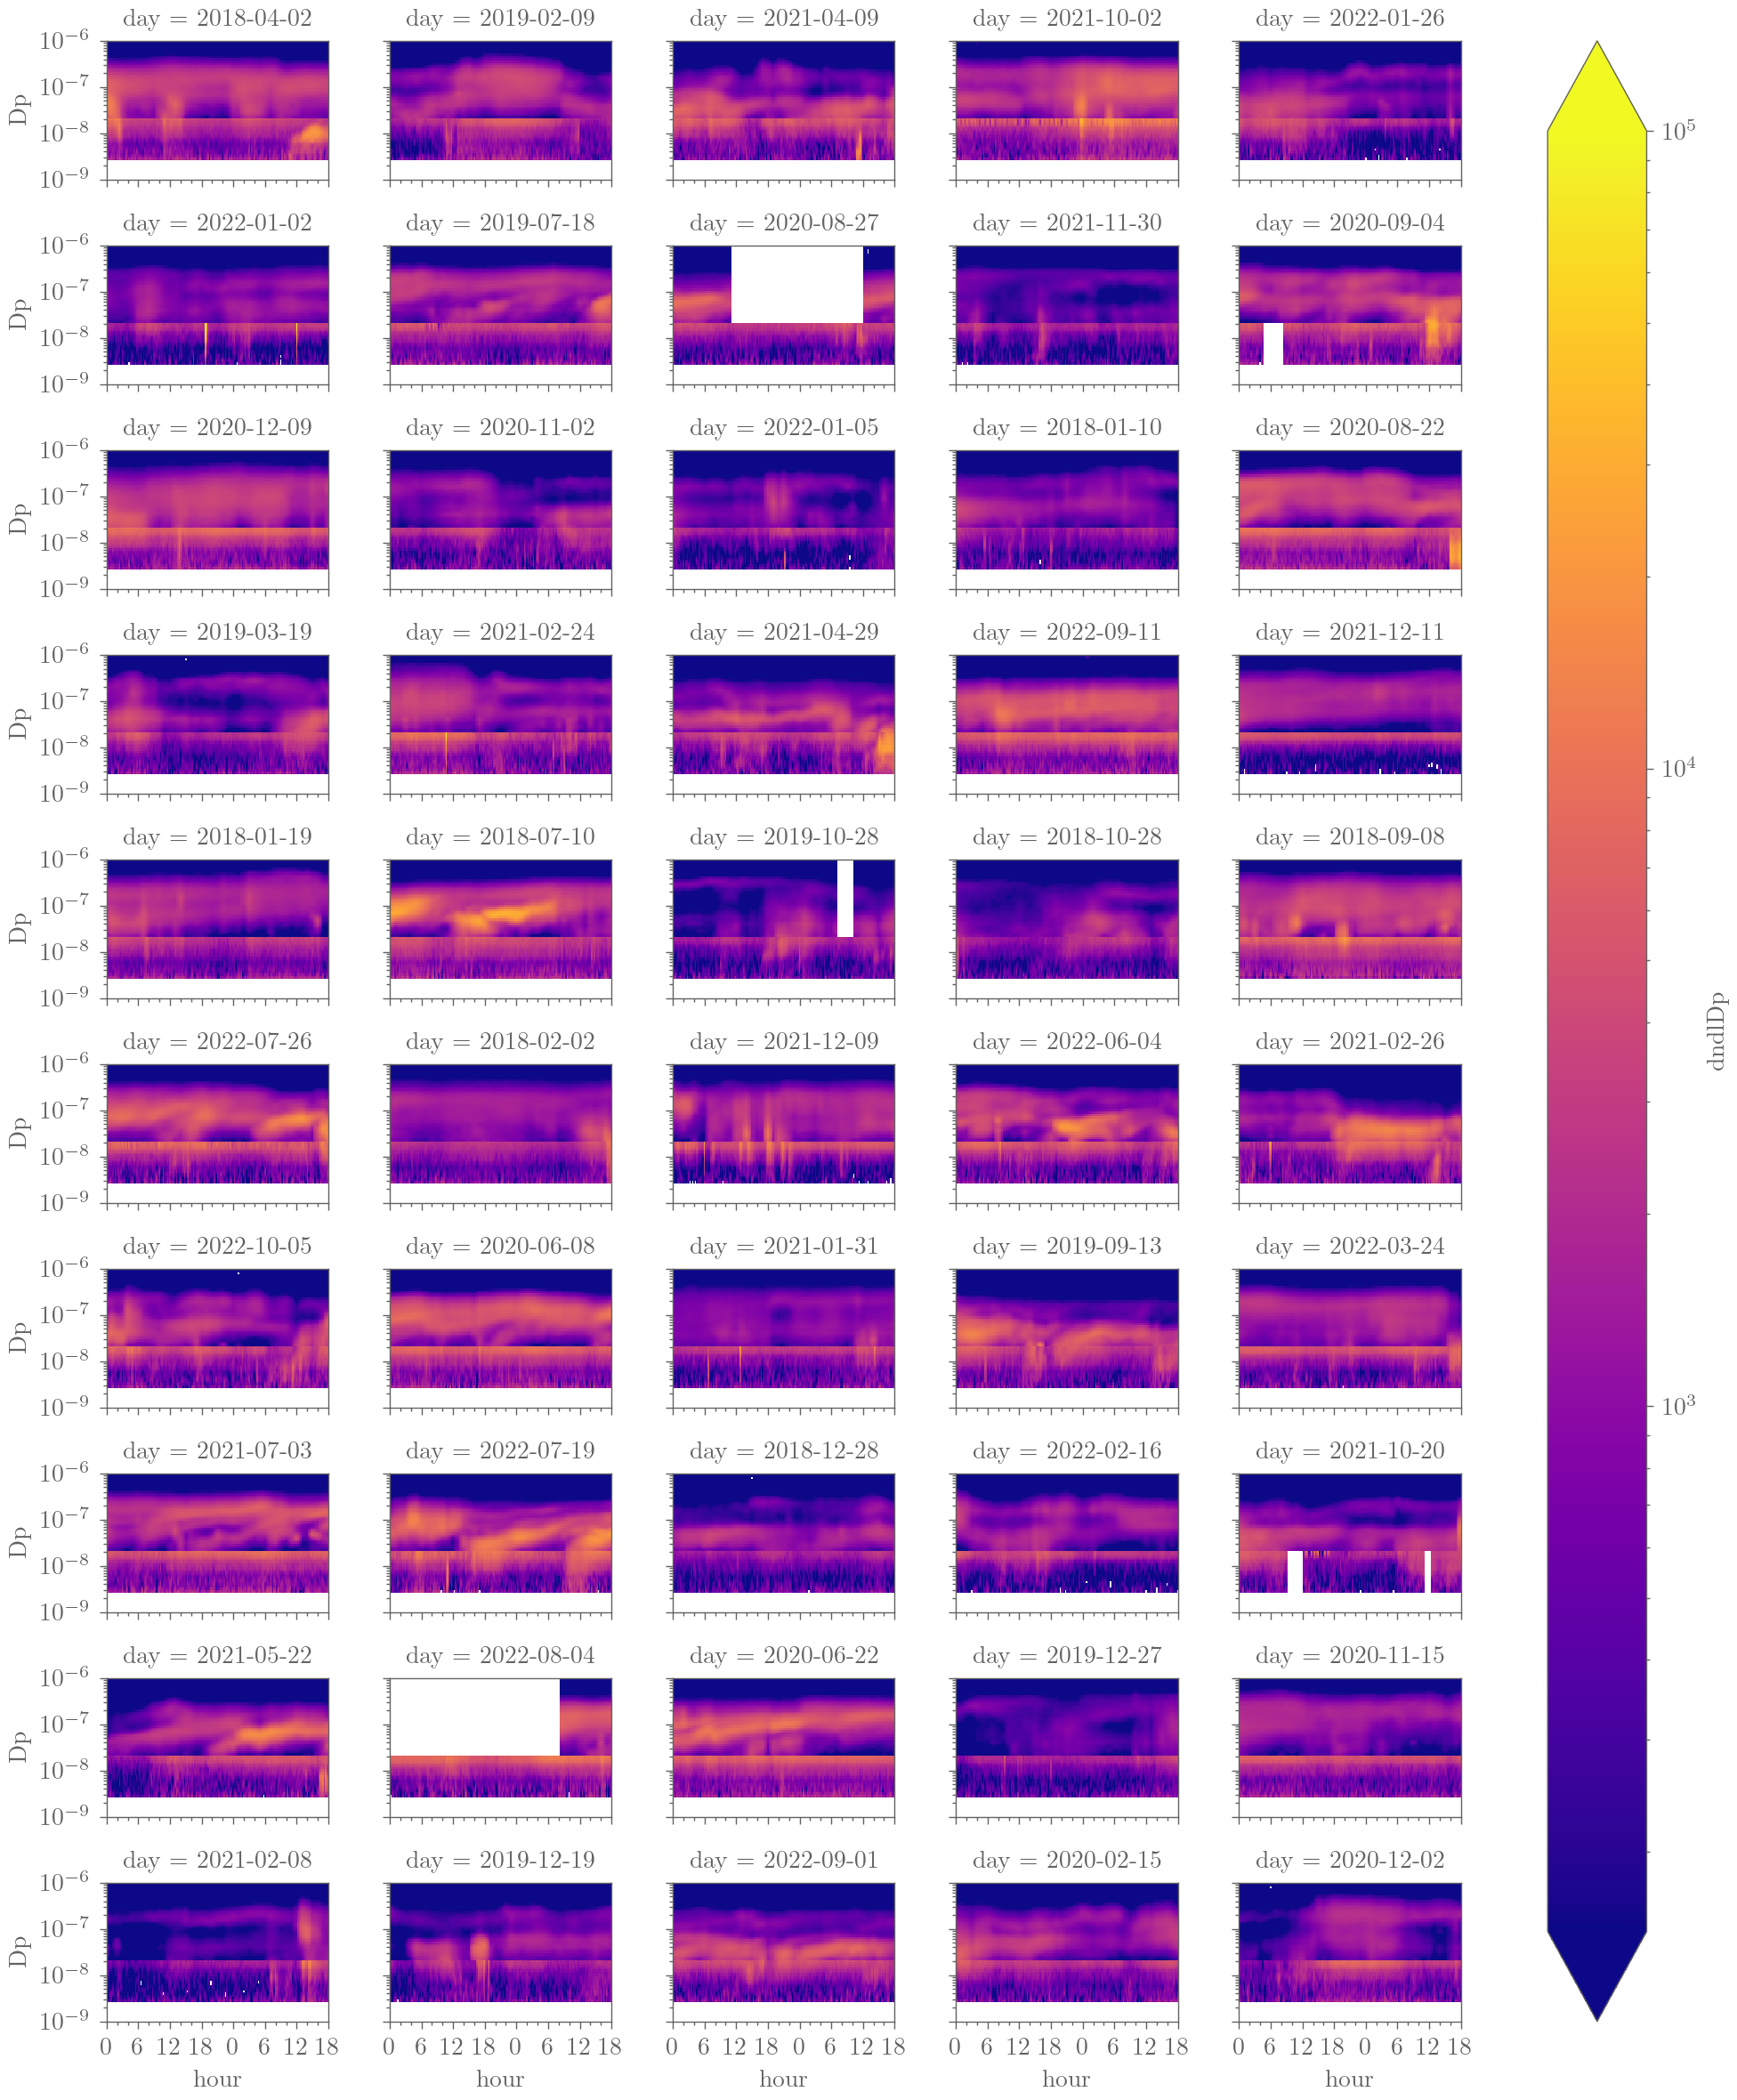

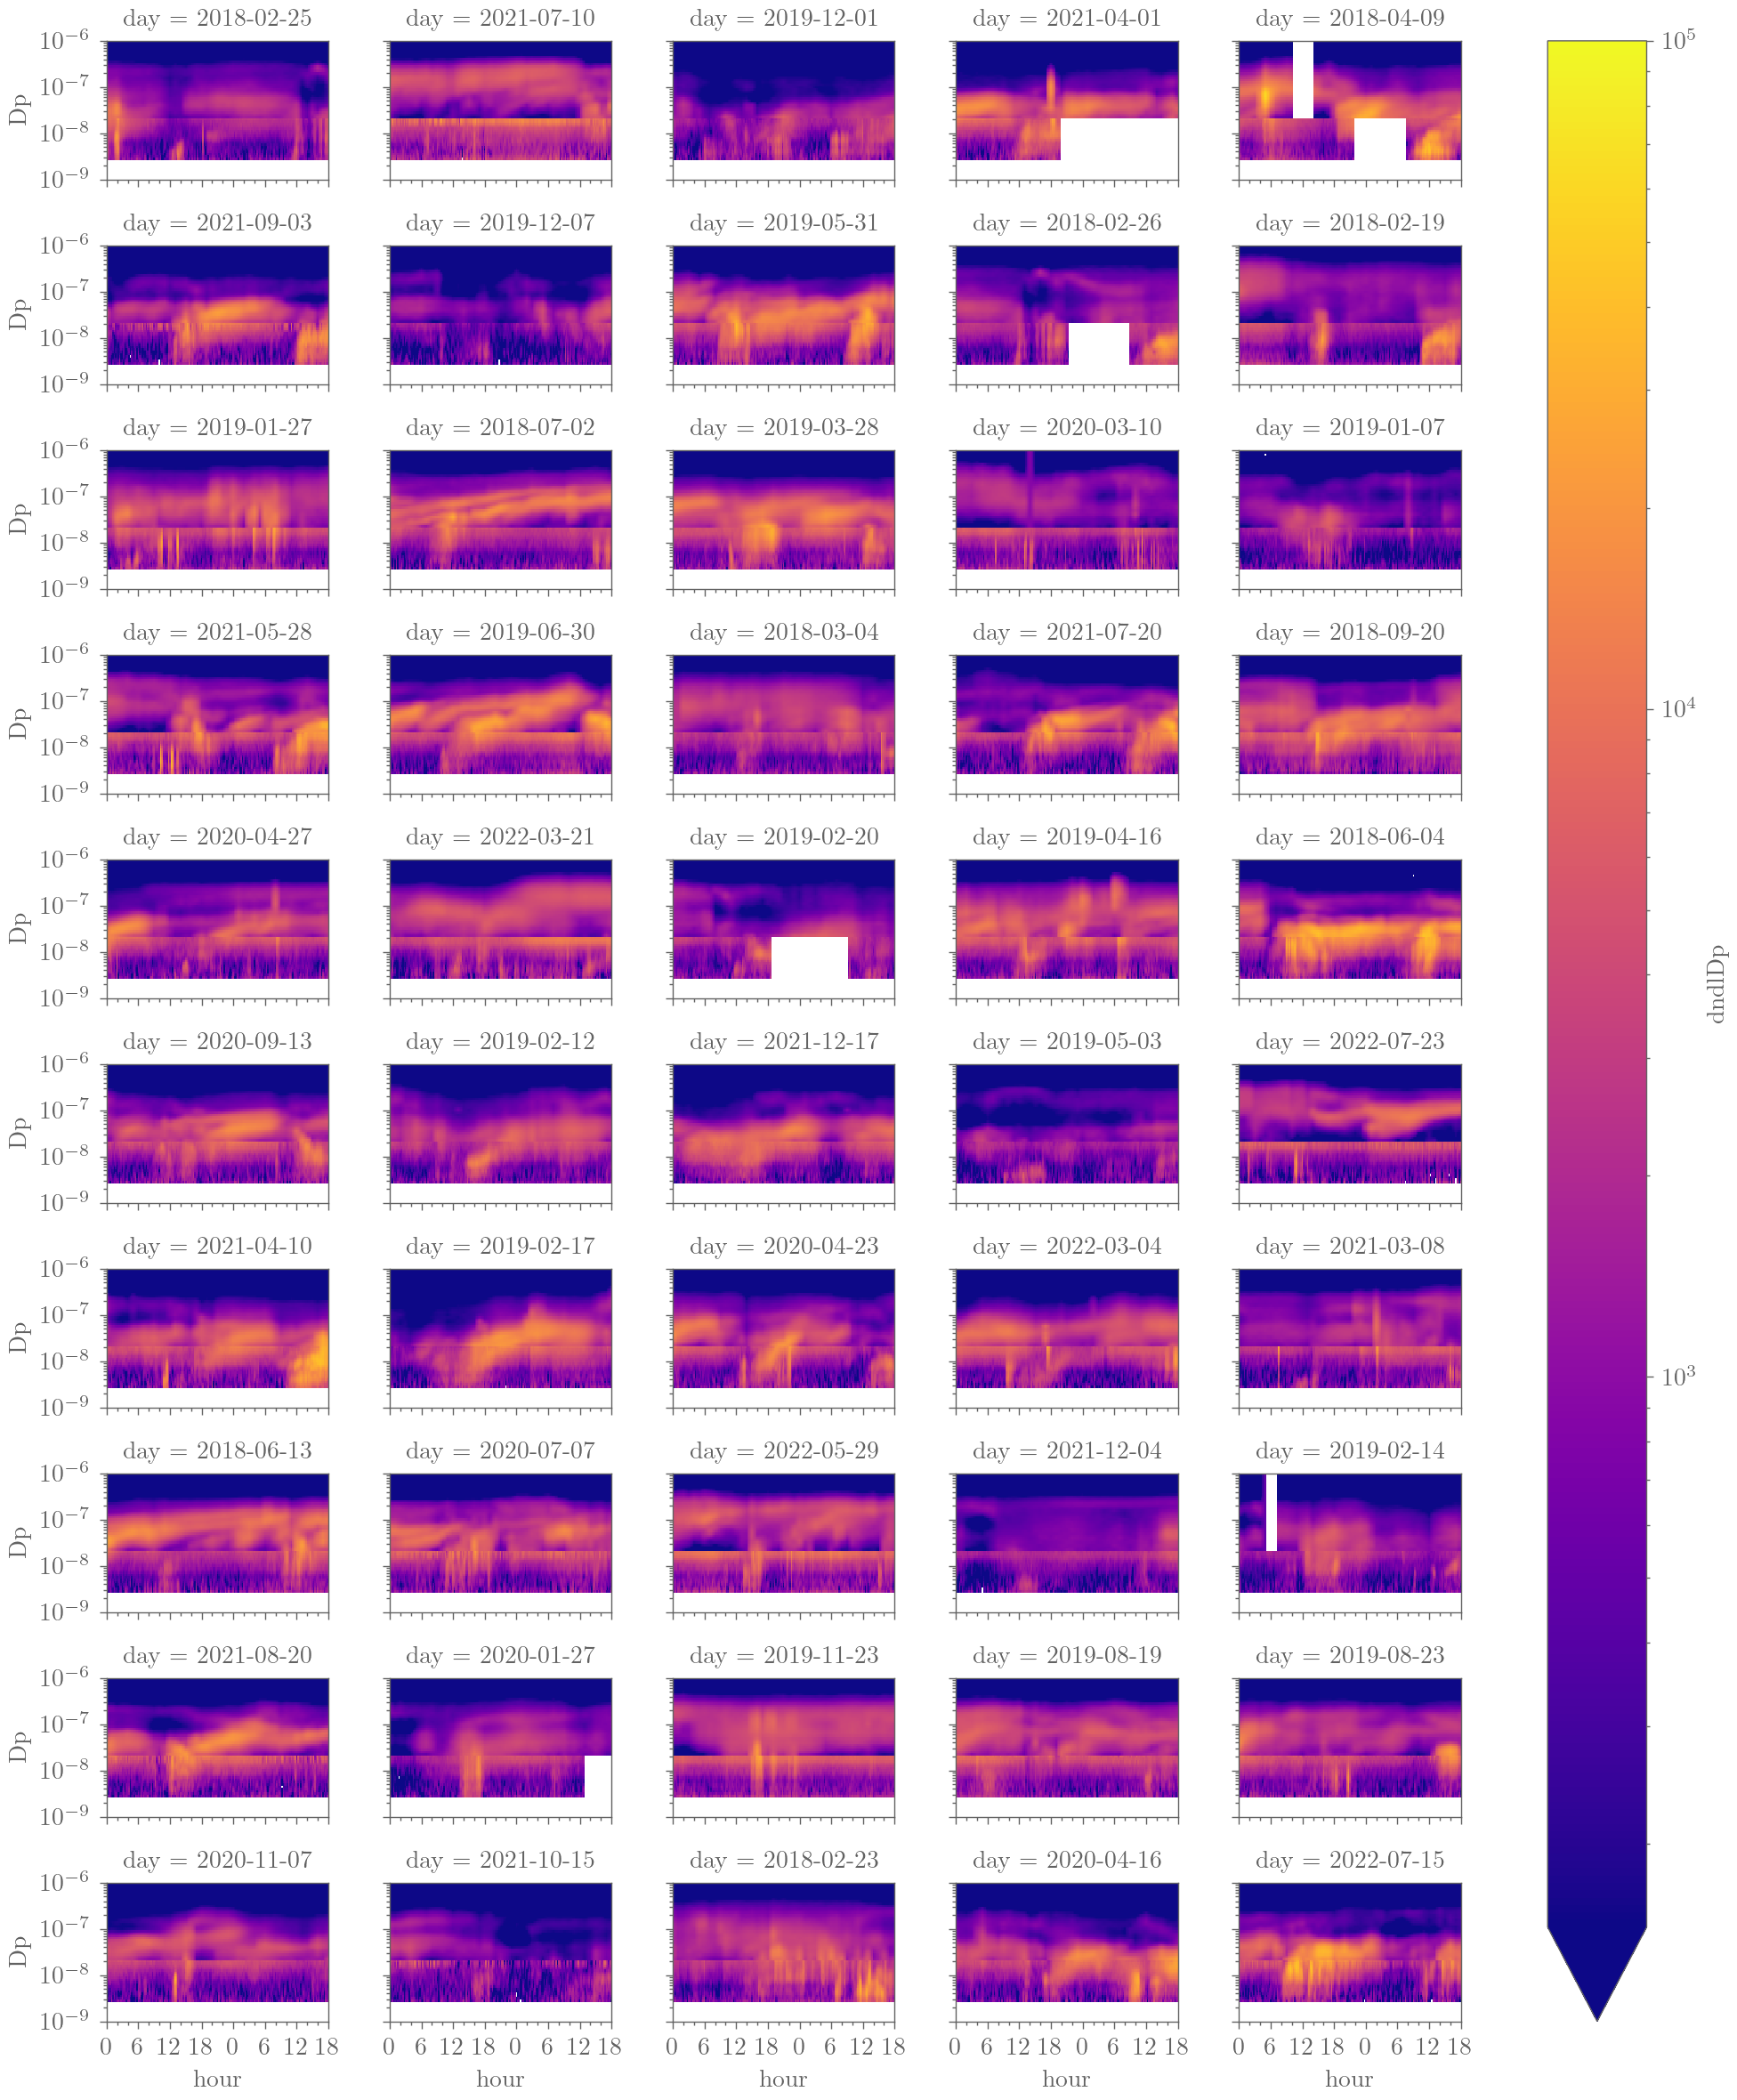

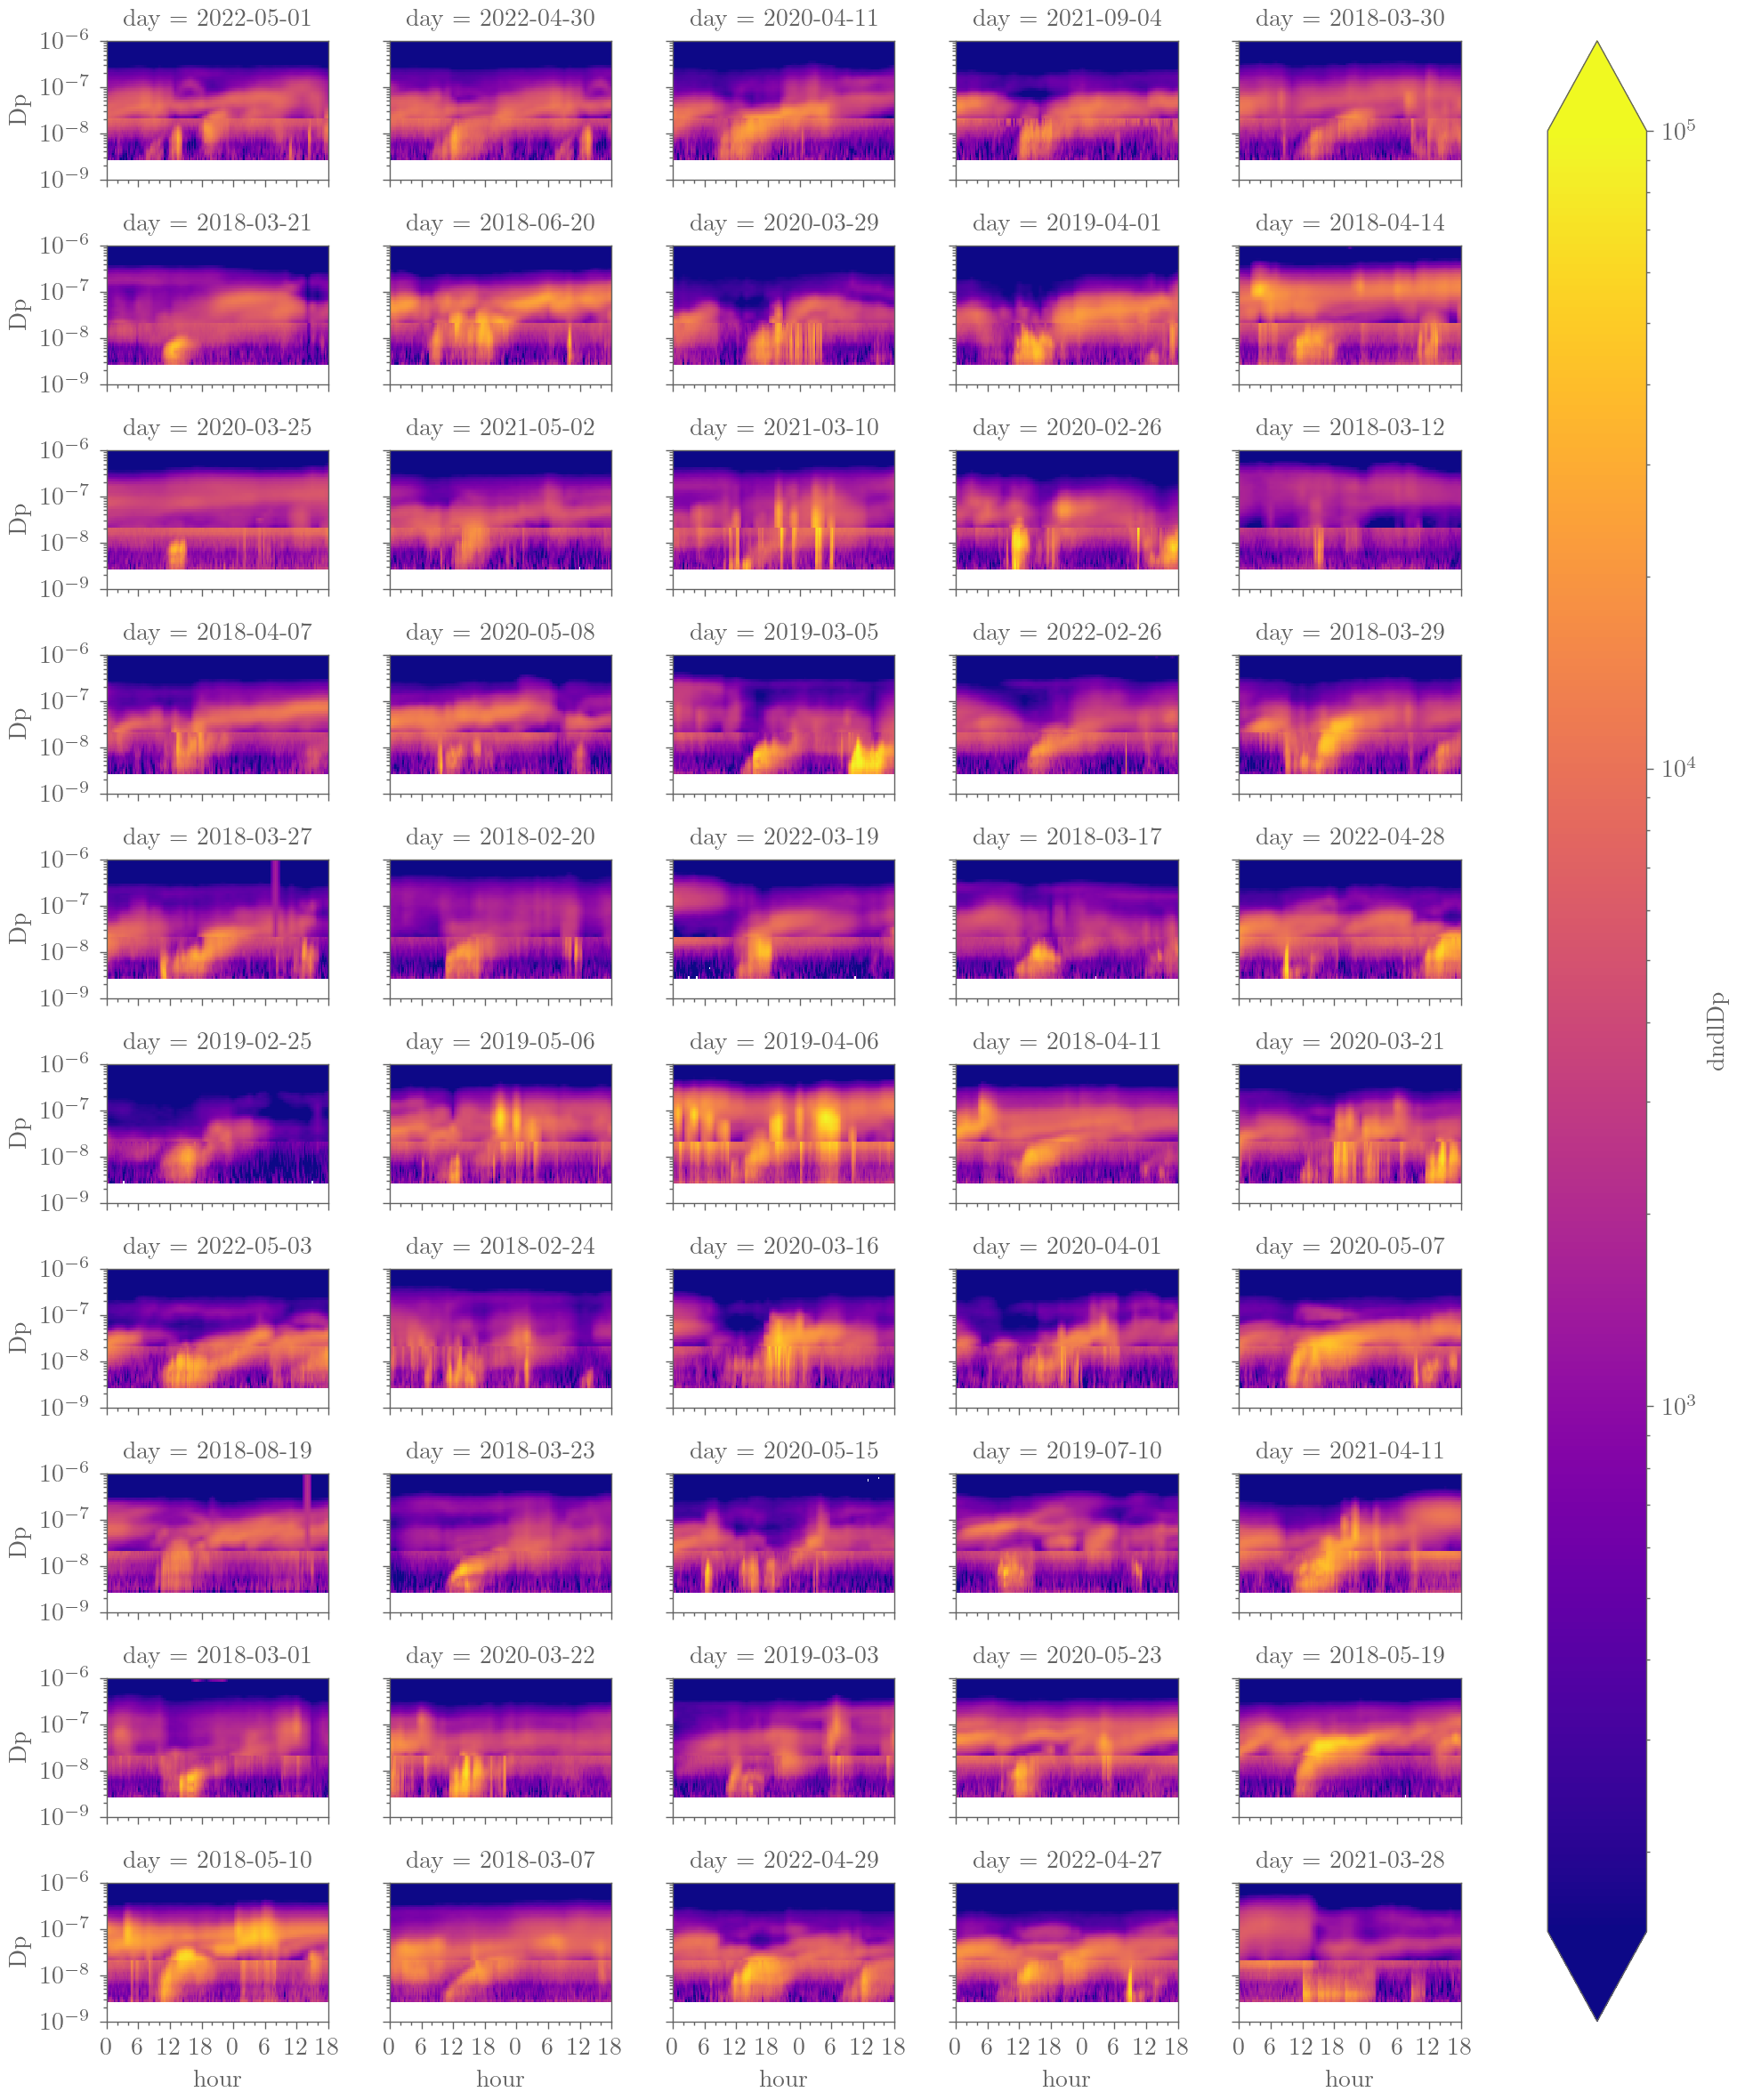

In [33]:
#region sciplot
# noinspection PyUnresolvedReferences
import scienceplots
plt.style.use([
    'default',
    'acp',
    #'notebook',
    # 'sp-grid',
    'no-black',
    'illustrator-safe'
])
#endregion sciplot
for g in ['g1','g2','g3']:
    res = (
        d5
        [['dndlDp','g']]
        .where(lambda d:d['g']==g,drop=True)
        .pipe(lambda d: d.loc[{'day':d['day'].to_series().sample(5*10).to_xarray()}])
        .loc[{'id':'nd'}]
        ['dndlDp']
        .plot(
            y='Dp',
            yscale='log',
            norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=10e4),
            cmap = 'plasma',
            col='day',
            col_wrap=5,
            size=1.2,
            aspect = 1.6,
            rasterized = True
        )

    )



    for ax in res.axs.flat:
        ax:plt.Axes
        ax.set_box_aspect(1/1.6)
        yy = 36 + 6
        ax.set_xlim(0,yy)
        ax.set_ylim(1e-9,1e-6)
        ti = np.arange(0, yy + 1, 6)
        ax.set_xticks(ti)
        ax.set_xticks(np.arange(0, yy+1, 2), minor=True)
        ax.set_xticklabels(np.mod(ti,24))

In [34]:
se = (
    d5
    ['d_lN']
    .squeeze()
    .to_series()
)

In [35]:
m12

2.492370478683177

(1.0, 4.5)

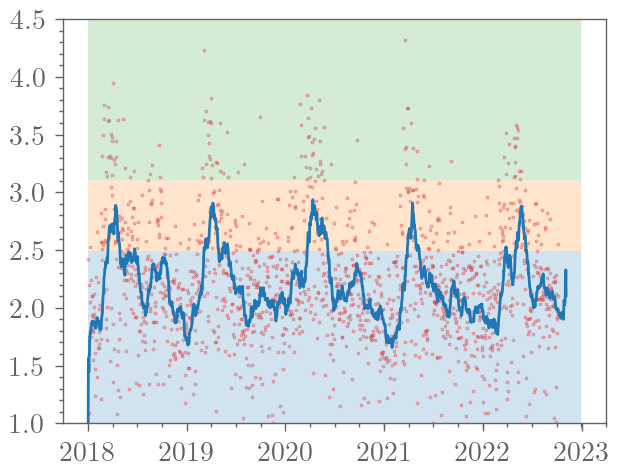

In [36]:
f, ax = plt.subplots()
f:plt.Figure
ax: plt.Axes

ax.fill_between(se.index,0,m12,alpha=.2)
ax.fill_between(se.index,m12,m23,alpha=.2)
ax.fill_between(se.index,m23,5,alpha=.2)
ax.scatter(se.index,se,s=.1,alpha=.5)
ax.plot(se.index,se.rolling('30D').mean())
ax.set_ylim(1,4.5)

In [37]:
def compressed_netcdf_save(ds, path, shuffle=True, complevel=4, fletcher32=True, encode_u=False):
    encoding = {}
    for k, v in ds.variables.items():
        encoding[k] = {
            'zlib'      : True,
            'shuffle'   : shuffle,
            'fletcher32': fletcher32,
            'complevel' : complevel
        }
        if encode_u:
            if v.dtype.kind == 'U':
                encoding[k]['dtype'] = 'S1'
    ds.to_netcdf(path, encoding=encoding)

In [38]:
(
    d5
    .drop('Dp_interval')
    .assign_coords({'qCut':lambda d:d['qCut'].astype('str')})
).to_netcdf('../data/d1/ds_5.nc')